# Predict continuous Big Five scores

## Import packages

In [40]:
import pandas as pd
from tqdm.notebook import tqdm
from time import time
import random
random.seed(32)
import sklearn
# from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold, mutual_info_classif, RFE, SequentialFeatureSelector
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import numpy as np
np.set_printoptions(precision=4, suppress=True)
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pathlib import Path
import pickle

import datetime

## Import data

In [2]:
# read in normal dataset
df = pd.read_pickle("b5feat.pkl")
df.name = 'allfeatures_df'
df = df[df['trait', 'openness'].notna()]
df = df[df['trait', 'conscientiousness'].notna()]
df = df[df['trait', 'extraversion'].notna()]
df = df[df['trait', 'agreeableness'].notna()]
df = df[df['trait', 'neuroticism'].notna()]
df.name = 'allfeatures_df'
df.trait.info()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1568 entries, -Areopagan- to zyzee
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   agreeableness      1568 non-null   float32
 1   openness           1568 non-null   float32
 2   conscientiousness  1568 non-null   float32
 3   extraversion       1568 non-null   float32
 4   neuroticism        1568 non-null   float32
 5   big5_a             1568 non-null   int16  
 6   big5_o             1568 non-null   int16  
 7   big5_c             1568 non-null   int16  
 8   big5_e             1568 non-null   int16  
 9   big5_n             1568 non-null   int16  
 10  big5_a_multi       1568 non-null   int16  
 11  big5_o_multi       1568 non-null   int16  
 12  big5_c_multi       1568 non-null   int16  
 13  big5_e_multi       1568 non-null   int16  
 14  big5_n_multi       1568 non-null   int16  
dtypes: float32(5), int16(10)
memory usage: 73.5+ KB
<class 'pandas.cor

## Trait

In [3]:
#split dataset in features and target variable depending on which trait to focus on
def trait(df, trait_name):
    featuredf = df.drop(['trait'], axis=1, level=0)
    try:
        featuredf.drop(['text'], axis=1, level=0, inplace=True)
    except KeyError:
        pass
    try:
        featuredf.drop(['data'], axis=1, level=0, inplace=True)
    except KeyError:
        pass
    feature_cols = featuredf.columns.tolist()
    
    x = df[feature_cols]     
    y = df['trait', trait_name]
    return x,y 

### Functions for nested stratified cross validation

In [33]:
# get names of the features
def get_names(x, pipeline):
    features = pipeline.named_steps['feature_selection']
    names = x.columns[features.get_support(indices=True)]
    return names

def get_pvalues(pipeline, x):
#     x_indices = np.arange(x.shape[-1])
#     selector = SelectKBest(f_classif, k=30)
#     selector.fit(x_train, y_train)
#     scores = -np.log10(selector.pvalues_)
    features = pipeline.named_steps['feature_selection']
    pvalues = features.pvalues_
#     pvalues /= pvalues.max()
    dfpvalues = pd.DataFrame(features.pvalues_)
    dfscores = pd.DataFrame(features.scores_)
    dfcolumns = pd.DataFrame(x.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores, dfpvalues],axis=1)
    featureScores.columns = ['specs','score', 'pvalue']
    featureScores.sort_values(by='pvalue')

    plt.figure(figsize = (12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(pvalues, bins=20)
    plt.title('All p-values')
    plt.subplot(1, 2, 2)
    smallpvalues = pvalues[pvalues<0.1]
    plt.hist(smallpvalues, bins=10)
    plt.title('Small p-values')
    
    plt.suptitle("Histograms of the p-values")
    plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.4,  
                    hspace=0.4) 
    plt.show()
    
    return featureScores

def get_classifier(classifier):
    if classifier == 'linear':
        return LinearRegression(n_jobs=-1)
    elif classifier == 'rfc_reg':
        return RandomForestRegressor(n_jobs=-1)
    elif classifier == 'boost_reg':
        return GradientBoostingRegressor(random_state=0)

    
def get_featureselection(fs, classifier, n_feat):
    if fs == 'anova':
        return SelectKBest(f_classif, k=n_feat)
    if fs == 'mutual':
        return SelectKBest(mutual_info_classif, k=n_feat)
    if fs == 'sequential_forward':
        return SequentialFeatureSelector(get_classifier(classifier), n_features_to_select=n_feat, direction='forward', n_jobs=-1)
    if fs == 'sequential_backward':
        return SequentialFeatureSelector(get_classifier(classifier), n_features_to_select=n_feat, direction='backward', n_jobs=-1)


    
def create_pipeline_cv(classifier, fs, dim, n_feat):
    if dim:
        pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('pca', PCA(n_components=100)),
              ('feature_selection',  get_featureselection(fs, classifier, n_feat)),
              ('classification', get_classifier(classifier))
            ])
    else:
        pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('feature_selection',  get_featureselection(fs, classifier, n_feat)),
              ('classification', get_classifier(classifier))
            ])
    return pipeline


def define_outputname(traits, df, option, fs, dim, n_feat, train=False):
    if train:
        if len(traits) ==1:
            outputname =  "train_"  +str(option) +"_" +str(fs) +"_PCA" +str(dim) +"_"+str(n_feat)
        else:
            outputname =  "train_"  +str(option) +"_" +str(fs) +"_PCA" +str(dim) +"_"+str(n_feat)
 
    else:
        if len(traits) ==1:
            outputname = str(option) +"_" +str(fs) +"_PCA" +str(dim) +"_"+str(n_feat)
        else:
            outputname = str(option) +"_"   +str(fs) +"_PCA" +str(dim) +"_"+str(n_feat)

    return outputname


def linear_plot(val_target, y_pred, outputname, trait_name):
    linear_plot = sns.regplot(x=val_target, y=y_pred, ci=None,  scatter_kws={"color": "blue"}, line_kws={"color": "red"})
    # color="b"
#     plt.savefig(Path(p, outputname + "_" + trait_name + '_ytruepred_plot.png'))
    return linear_plot

def save_predictors(names, predictors_fold1, predictors_fold2, predictors_fold3, predictors_fold4, predictors_fold5, j):
    if j==1:
        predictors_fold1.append(list(names))
    elif j==2:
        predictors_fold2.append(list(names))
    elif j==3:
        predictors_fold3.append(list(names))
    elif j==4:
        predictors_fold4.append(list(names))
    elif j==5:
        predictors_fold5.append(list(names))
    return predictors_fold1, predictors_fold2, predictors_fold3, predictors_fold4, predictors_fold5

def save_coefficients(coefficients, coef_fold1, coef_fold2, coef_fold3, coef_fold4, coef_fold5, j):
    if j==1:
        coef_fold1.append(list(coefficients))
    elif j==2:
        coef_fold2.append(list(coefficients))
    elif j==3:
        coef_fold3.append(list(coefficients))
    elif j==4:
        coef_fold4.append(list(coefficients))
    elif j==5:
        coef_fold5.append(list(coefficients))
    return coef_fold1, coef_fold2, coef_fold3, coef_fold4, coef_fold5

## Regression

In [48]:
def regress(df, traits, clf_lst, fs, dim, n_feat,train=False):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        print("Current time: ", str(datetime.datetime.now()))
        tstart=time()
        for option in clf_lst:
            print("Classifier: ", option, "\n")
            outputname = define_outputname(traits, df, option, fs, dim, n_feat)
            output = {'Traits': traits}
            
            # empty lists to save data in csv
            predictors_fold1, predictors_fold2, predictors_fold3, predictors_fold4, predictors_fold5 = [],[],[],[],[]
            rsquared_traits, mse_traits = [], []
            if option == 'linear':
                coef_fold1, coef_fold2, coef_fold3, coef_fold4, coef_fold5  = [],[],[],[],[]

    
            for trait_name in traits:
                print("\nTrait to predict: ", trait_name, "(", option, ")\n")
                x,y = trait(df, trait_name)
                cv_outer = KFold(n_splits=5, shuffle=True, random_state=0)
                cv_outer_lst = cv_outer.split(x)
                
                # empty lists for saving        
                rsquared_lst, mse_lst, ytrue_lst, ypred_lst = [],[],[],[]

                plt.figure(figsize=(5, 5))
                p = Path('/home/sophia/ma_py/Big5-NLP/results/')
                j=1
                for train_idx, val_idx in cv_outer_lst:
                    train_data, val_data = x.iloc[train_idx], x.iloc[val_idx]
                    train_target, val_target = y.iloc[train_idx], y.iloc[val_idx]
                    
#                     print("Fold No. ", j)
#                     print("Length of train and test: ", len(train_data), len(val_data))
#                     print("Total users in this fold: ", (len(train_data) + len(val_data)))

#                     print("\nCreate pipeline with", option, "(Fold", j,"), for trait: ", trait_name, "...\n")
            
                    clf = create_pipeline_cv(option, fs, dim, n_feat)
                    clfnew = clf.fit(train_data, train_target)
                    if dim == False:
                        names = get_names(train_data, clfnew)
                        predictors_fold1, predictors_fold2, predictors_fold3, predictors_fold4, predictors_fold5 = save_predictors(names, predictors_fold1, predictors_fold2, predictors_fold3, predictors_fold4, predictors_fold5, j)
                    
                    if train: 
                        y_pred = clfnew.predict(train_data)
                        score = clf.score(train_data, train_target)
                        mse = mean_squared_error(train_target, y_pred)
                        ytrue_lst.append(train_target)
                        
                    else:
                        y_pred = clfnew.predict(val_data)
                        score = clf.score(val_data, val_target)
                        mse = mean_squared_error(val_target, y_pred)
                        ytrue_lst.append(val_target)
                        
                    ypred_lst.append(y_pred)
                        
                    if option == 'linear':
                        coefficients = clf.named_steps['classification'].coef_
                        coef_fold1, coef_fold2, coef_fold3, coef_fold4, coef_fold5 = save_coefficients(coefficients, coef_fold1, coef_fold2, coef_fold3, coef_fold4, coef_fold5, j)
                    rsquared_lst.append(score)
                    mse_lst.append(mse)

#                         linear_plot = linear_plot(val_target, y_pred, outputname, trait_name)
#                         plt.show()


                    j+=1
                    
                    
                  # Average results
                r_avg = np.mean(rsquared_lst)
                rsquared_traits.append(round(r_avg, 4))
                mse_avg = np.mean(mse_lst)
                mse_traits.append(round(mse_avg, 4))
                print("Average score (R squared): ", r_avg, "\nAverage MSE: ", mse_avg)

                all_ytrue = np.concatenate(ytrue_lst)
                all_ypred = np.concatenate(ypred_lst)
                print(len(all_ytrue))
                print(len(all_ypred))
                title = 'Regression plot for trait ' + trait_name 
                plot = linear_plot(all_ytrue, all_ypred, outputname, trait_name)
                plt.xlim([1, 101])
                plt.ylim([1, 101])
                plt.ylabel('True scores')
                plt.xlabel('Predicted scores')
                plt.axes().set_aspect('equal', 'datalim')
                plt.title(title)
                plt.savefig(Path(p, outputname + "_" + trait_name + '_linearplot.png'))
                plt.show()

            print("Total r squared: ", np.mean(rsquared_traits), "Total MSE: ", np.mean(mse_traits))
            output.update({'rsquared': rsquared_traits, 'MSE': mse_traits})
            if dim==False:
                output.update({'predictors_fold1': predictors_fold1, 'predictors_fold2': predictors_fold2, 'predictors_fold3': predictors_fold3, 'predictors_fold4': predictors_fold4, 'predictors_fold5': predictors_fold5})
            if option=='linear':
                output.update({'coef_fold1': coef_fold1, 'coef_fold2': coef_fold2, 'coef_fold3': coef_fold3, 'coef_fold4': coef_fold4, 'coef_fold5': coef_fold5})
            outputdf = pd.DataFrame(output)
            outputdf.to_csv(Path(p, outputname + '.csv'), index=False)
            print("Time for entire process: %0.2fs" % (time() - tstart))

            

big5_traits = ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']
regres = ['linear', 'rfc_reg', 'boost_reg']

## Regressions on continuous traits

Current time:  2021-05-17 08:56:24.626255
Classifier:  linear 


Trait to predict:  openness ( linear )

Average score (R squared):  -1.617674792009798e+27 
Average MSE:  1.2555056217190871e+30
1568
1568


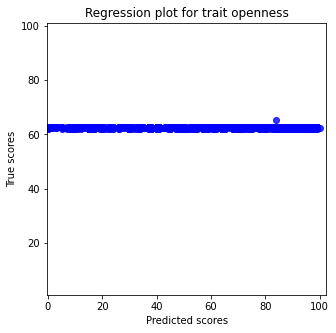


Trait to predict:  conscientiousness ( linear )

Average score (R squared):  -3.700979038568101e+24 
Average MSE:  3.3066766711935634e+27
1568
1568


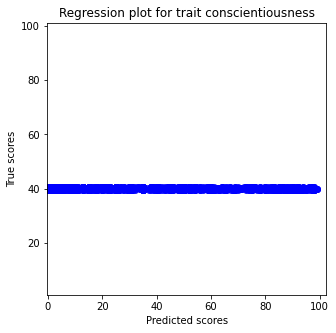


Trait to predict:  extraversion ( linear )

Average score (R squared):  -1.112041892040261e+26 
Average MSE:  1.007820011774582e+29
1568
1568


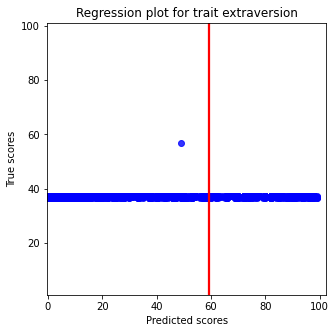


Trait to predict:  agreeableness ( linear )

Average score (R squared):  -9.802482135072503e+24 
Average MSE:  9.68502896176204e+27
1568
1568


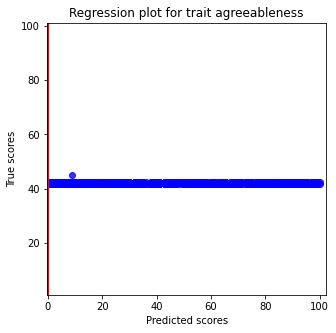


Trait to predict:  neuroticism ( linear )

Average score (R squared):  -4.4347621009436025e+28 
Average MSE:  4.746043720956813e+31
1568
1568


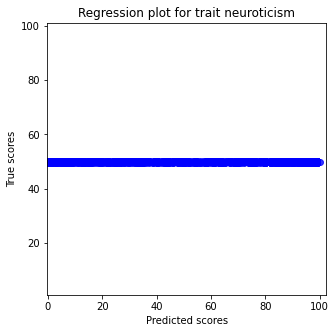

Total r squared:  -9.218000690364698e+27 Total MSE:  9.765943307619526e+30
Time for entire process: 38.51s
Classifier:  rfc_reg 


Trait to predict:  openness ( rfc_reg )

Average score (R squared):  -0.0011929536904019765 
Average MSE:  772.8438559445282
1568
1568


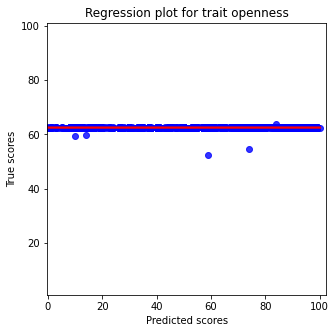


Trait to predict:  conscientiousness ( rfc_reg )

Average score (R squared):  -0.004093279731462074 
Average MSE:  923.3894019218285
1568
1568


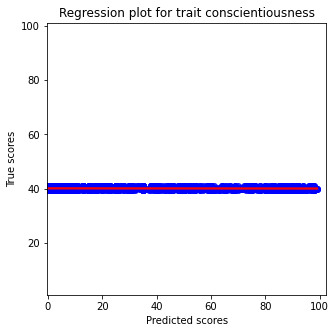


Trait to predict:  extraversion ( rfc_reg )

Average score (R squared):  -0.0013056972491959583 
Average MSE:  927.747986765804
1568
1568


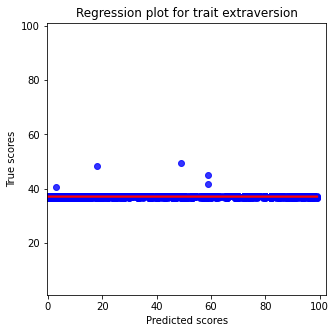


Trait to predict:  agreeableness ( rfc_reg )

Average score (R squared):  -0.0035756058336842145 
Average MSE:  959.5024123428022
1568
1568


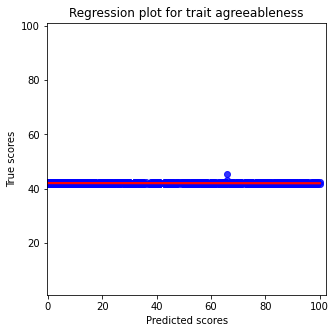


Trait to predict:  neuroticism ( rfc_reg )

Average score (R squared):  -0.0013900847507907876 
Average MSE:  1047.4583768436805
1568
1568


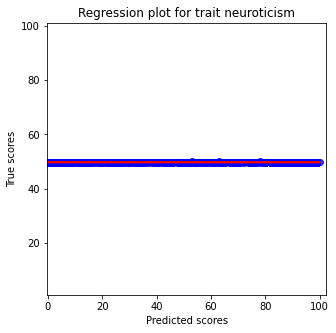

Total r squared:  -0.00232 Total MSE:  926.1884200000001
Time for entire process: 84.84s
Classifier:  boost_reg 


Trait to predict:  openness ( boost_reg )

Average score (R squared):  -0.001564755880576274 
Average MSE:  773.1208855233492
1568
1568


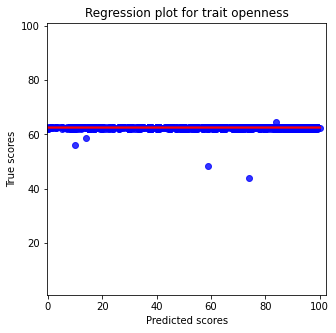


Trait to predict:  conscientiousness ( boost_reg )

Average score (R squared):  -0.003995507159364831 
Average MSE:  923.3012426994392
1568
1568


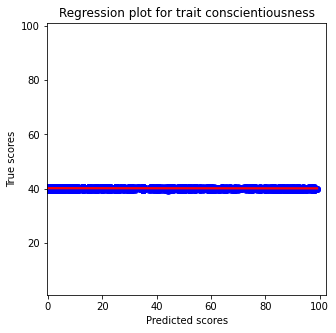


Trait to predict:  extraversion ( boost_reg )

Average score (R squared):  -0.001999507212357754 
Average MSE:  928.3891130171323
1568
1568


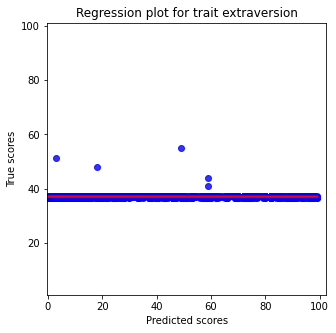


Trait to predict:  agreeableness ( boost_reg )

Average score (R squared):  -0.0033626866051081005 
Average MSE:  959.3010142743678
1568
1568


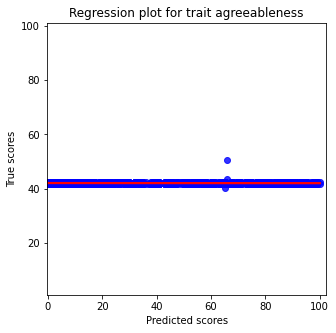


Trait to predict:  neuroticism ( boost_reg )

Average score (R squared):  -0.0014120331073156577 
Average MSE:  1047.4816766104893
1568
1568


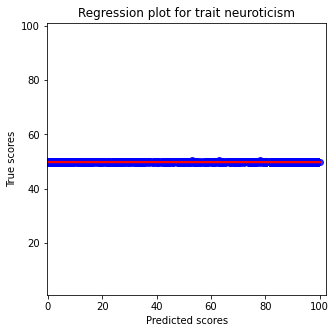

Total r squared:  -0.00248 Total MSE:  926.31878
Time for entire process: 123.83s


In [43]:
regress(df, big5_traits, regres, 'anova', dim=False, n_feat=10)

Current time:  2021-05-17 09:02:35.310836
Classifier:  linear 


Trait to predict:  openness ( linear )

Average score (R squared):  -0.0009099369539466107 
Average MSE:  773.4168224117354
6272
6272


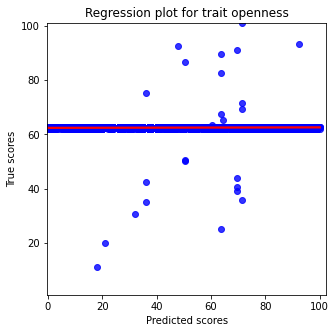


Trait to predict:  conscientiousness ( linear )

Average score (R squared):  -0.002528696946514586 
Average MSE:  924.2037944579084
6272
6272


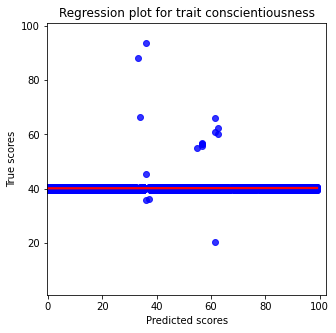


Trait to predict:  extraversion ( linear )

Average score (R squared):  0.0002688382119172106 
Average MSE:  926.9561622035365
6272
6272


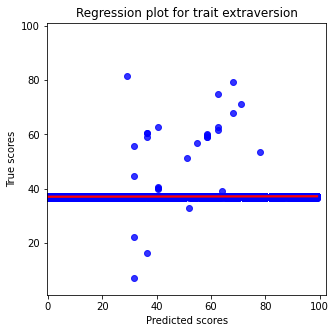


Trait to predict:  agreeableness ( linear )

Average score (R squared):  0.00019394054879668944 
Average MSE:  957.9603448695128
6272
6272


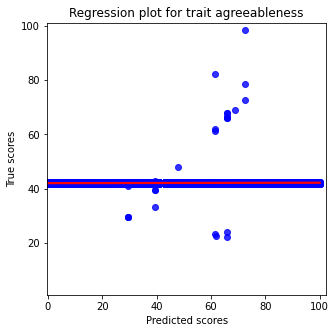


Trait to predict:  neuroticism ( linear )

Average score (R squared):  -0.001167380845898669 
Average MSE:  1048.1643750784683
6272
6272


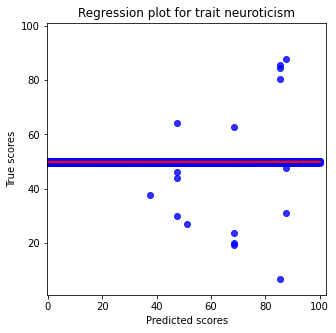

Total r squared:  -0.0008200000000000001 Total MSE:  926.1402999999998
Time for entire process: 46.47s
Classifier:  rfc_reg 


Trait to predict:  openness ( rfc_reg )

Average score (R squared):  0.001661392196759448 
Average MSE:  771.4318946253086
6272
6272


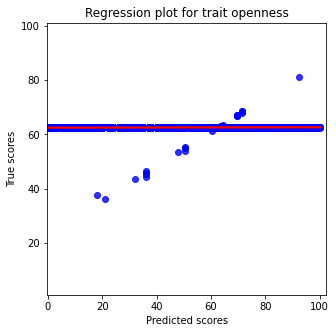


Trait to predict:  conscientiousness ( rfc_reg )

Average score (R squared):  0.0006824295691040705 
Average MSE:  921.2549685932299
6272
6272


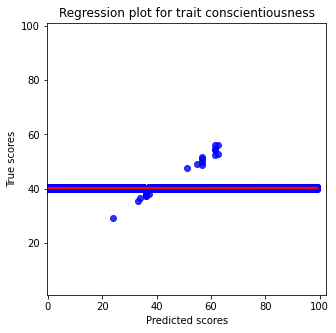


Trait to predict:  extraversion ( rfc_reg )

Average score (R squared):  0.0015137434064591115 
Average MSE:  925.8004188013434
6272
6272


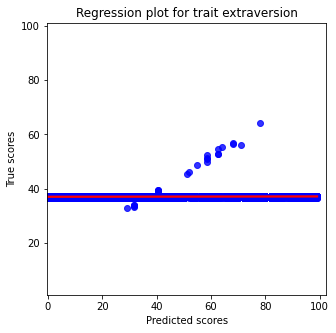


Trait to predict:  agreeableness ( rfc_reg )

Average score (R squared):  0.0015723468359405857 
Average MSE:  956.6402187605654
6272
6272


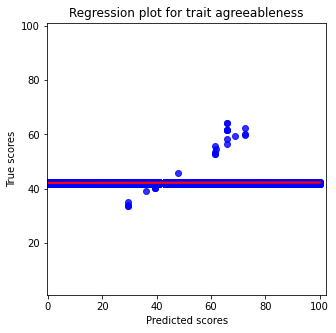


Trait to predict:  neuroticism ( rfc_reg )

Average score (R squared):  0.0016145215692785707 
Average MSE:  1045.246561577365
6272
6272


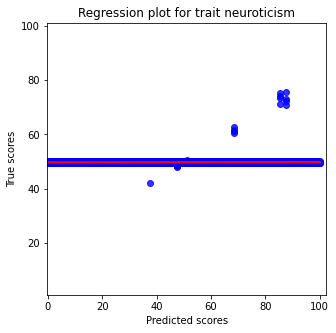

Total r squared:  0.0014199999999999998 Total MSE:  924.0748200000002
Time for entire process: 98.91s
Classifier:  boost_reg 


Trait to predict:  openness ( boost_reg )

Average score (R squared):  0.001960881856776053 
Average MSE:  771.1996008817509
6272
6272


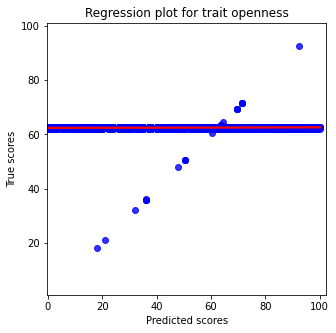


Trait to predict:  conscientiousness ( boost_reg )

Average score (R squared):  0.0008072198739434766 
Average MSE:  921.1397982796327
6272
6272


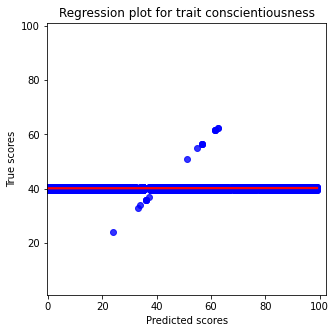


Trait to predict:  extraversion ( boost_reg )

Average score (R squared):  0.0017491440388932133 
Average MSE:  925.5823152310707
6272
6272


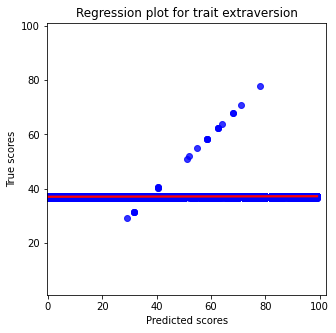


Trait to predict:  agreeableness ( boost_reg )

Average score (R squared):  0.0017747106933713175 
Average MSE:  956.4467639536697
6272
6272


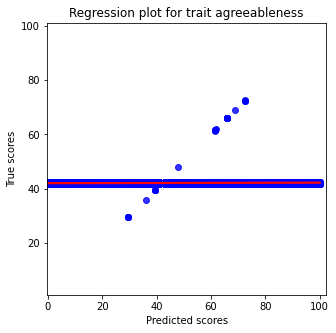


Trait to predict:  neuroticism ( boost_reg )

Average score (R squared):  0.0018765643806617938 
Average MSE:  1044.972052729429
6272
6272


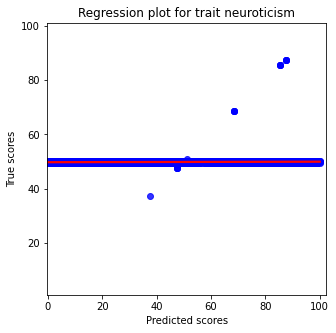

Total r squared:  0.0016400000000000002 Total MSE:  923.8681199999999
Time for entire process: 143.40s


In [46]:
regress(df, big5_traits, regres, 'anova', dim=False, n_feat=10, train=True)

In [ ]:
regress(df, big5_traits, regres, 'mutual', dim=True, n_feat=10)

In [ ]:
regress(df, big5_traits, regres, 'forward_sequential', dim=True, n_feat=10)